In [1]:
from IPython import get_ipython
import random
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd
import plotly.express as px
import statistics as s

In [2]:
import inspect
import dyna_env_drifttype
# 显示模块中的所有成员
#print(dir(dyna_env_drifttype))
from dyna_env_drifttype import TaskEnv_driftype
env = TaskEnv_driftype()
#print(env)

/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错


In [3]:
class Q_learning_Agent():
    def __init__(self,
                 env: TaskEnv_driftype,
                 exploration_rate: float = 0.1,
                 learning_rate: float = 0.2,
                 discount_factor: float = 1) -> int:
        self.epsilon = exploration_rate  # A random agent "explores" always, so epsilon will be 1
        self.alpha = learning_rate  # A random agent never learns, so there's no need for a learning rate
        self.gamma = discount_factor  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros((4,7), dtype=float) #+3 
        #self.q_table = np.zeros((4,7), dtype=float) #7个state 10个action

        self.actions = env.action_space
        
    def change_qtable(self):
        self.q_table = np.zeros((8,10),dtype=float) #state have TAU
        return

    def select_action(self, state, use_greedy_strategy: bool = False) -> int:
        #print("action space:",env.action_space)
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x = env.observation_space.columns.to_list().index(state)
        max_val = np.max(self.q_table[x, :])
        find_max_val = np.where(self.q_table[x, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):        
        # Helper variables to easily get the indices of the value
        x = env.observation_space.columns.to_list().index(state)
        next_max_val = 0
        if next_state != 'Tau':
           # print("length of observation space colummns",len(env.observation_space.columns))
            x_ = env.observation_space.columns.to_list().index(next_state)
            #print(x_)
            # Get the maximum value
            next_max_val = np.max(self.q_table[x_, :])
        # Update the value in the q-table using Q(S,A) <- Q(S,A) + alpha(R + gamma(max action value) - Q(S,A))
        self.q_table[x, action] += self.alpha * (reward + (self.gamma*next_max_val) - self.q_table[x, action])


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_experiment(apply_drift=False,add_actions=0, change_at_states=['va', 'po', 'sib', 'pp'], drift_dis_type='inverse',intensity = 0.5,drift_type='sudden'):
    """运行单个实验并返回奖励历史"""
    env = TaskEnv_driftype()
    agent = Q_learning_Agent(env)
    # 实验参数
    total_episodes = 1000
    drift_episode = 500  # 在第50个episode触发drift
    reward_history = []
    
    for episode in range(total_episodes):
        # 应用drift
        if apply_drift and episode == drift_episode:
            env.set_flag()
            env.drift(add_actions, change_at_states, drift_dis_type,intensity, drift_type)  # 仅改变转移概率
            print(f"Drift applied at episode {episode}")
        
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
        
        reward_history.append(episode_reward)
    return reward_history



def run_multiple_trials(apply_drift=False, num_runs=5):
    """多次运行实验并返回平均结果"""
    all_results = []
    
    for _ in tqdm(range(num_runs)):
        results = run_experiment(apply_drift)
        all_results.append(results)
    
    # 计算统计量
    avg_rewards = np.mean(all_results, axis=0)
    std_rewards = np.std(all_results, axis=0)
    
    return avg_rewards, std_rewards






# 可视化结果
def reward_plot(avg_no_drift,std_no_drift,avg_with_drift,std_with_drift):
    plt.figure(figsize=(12, 6))

    # 绘制无drift曲线
    plt.plot(avg_no_drift, label='No Drift', color='blue')
    plt.fill_between(range(len(avg_no_drift)),
                    avg_no_drift - std_no_drift,
                    avg_no_drift + std_no_drift,
                    alpha=0.2, color='blue')

    # 绘制有drift曲线
    plt.plot(avg_with_drift, label='With Drift', color='red')
    plt.fill_between(range(len(avg_with_drift)),
                    avg_with_drift - std_with_drift,
                    avg_with_drift + std_with_drift,
                    alpha=0.2, color='red')
    # 标记drift发生位置
    plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)
    plt.text(10, min(avg_no_drift)*0.9, 'Drift Start', rotation=0, color='gray')

    # 图表装饰
    plt.title('Average Reward with and without Concept Drift (5 runs average)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return

Running experiments without drift...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Py


Running experiments with drift...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Py

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 20%|██        | 1/5 [00:00<00:02,  1.50it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 40%|████      | 2/5 [00:01<00:01,  1.66it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 60%|██████    | 3/5 [00:01<00:01,  1.65it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 80%|████████  | 4/5 [00:02<00:00,  1.55it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


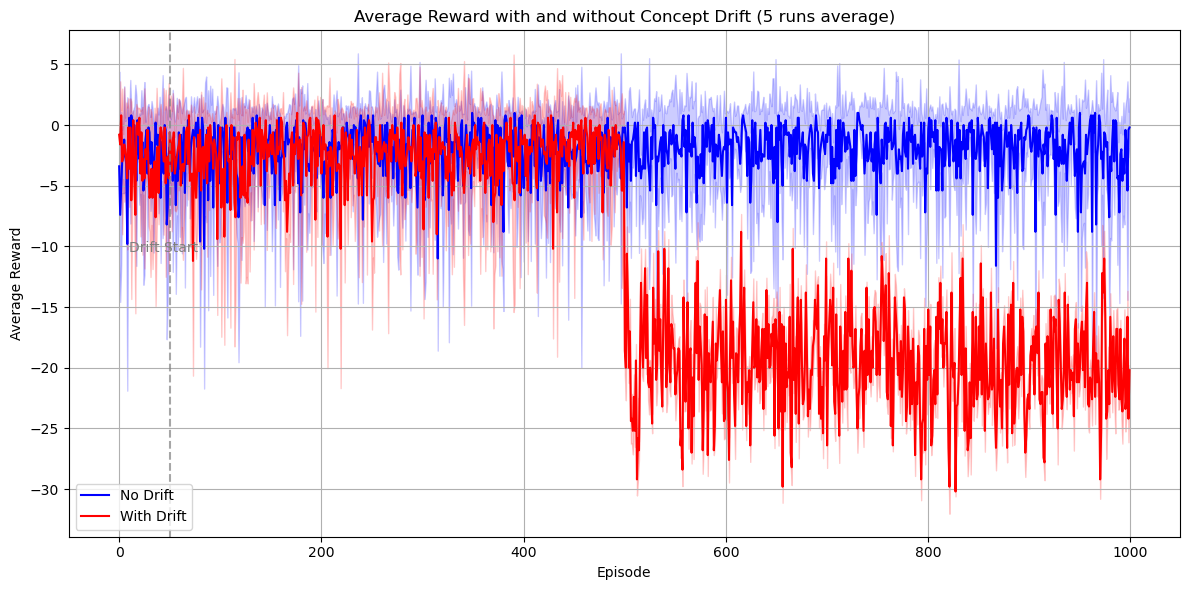

In [5]:
# 运行无drift和有drift的实验 , random sudden drift
print("Running experiments without drift...")
avg_no_drift, std_no_drift = run_multiple_trials(apply_drift=False)


print("\nRunning experiments with drift...")
avg_with_drift, std_with_drift = run_multiple_trials(apply_drift=True)



reward_plot(avg_no_drift,std_no_drift,avg_with_drift,std_with_drift)

Running experiments without drift...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Py


Running experiments with drift...


  0%|          | 0/5 [00:00<?, ?it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Py

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 20%|██        | 1/5 [00:00<00:02,  1.58it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 60%|██████    | 3/5 [00:01<00:01,  1.59it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

 80%|████████  | 4/5 [00:02<00:00,  1.61it/s]/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容

drift happen
1.0 [0.01603948 0.14497224 0.57001851 0.24676126 0.02220851]
new prob 1.0
1.0 [0.13498952 0.57497755 0.2481293  0.01945525 0.02244837]
new prob 1.0
1.0 [0.59183673 0.18367347 0.1377551  0.05612245 0.03061224]
new prob 1.0
1.0 [0.17118402 0.5149786  0.26248217 0.0256776  0.0256776 ]
new prob 1.0
1.0 [0.54969749 0.25842697 0.0207433  0.14952463 0.02160761]
new prob 0.9999999999999999
1.0000000000000002 [0.21645022 0.16883117 0.54978355 0.03463203 0.03030303]
new prob 1.0
0.9999999999999999 [0.44444444 0.00854701 0.37606838 0.06837607 0.1025641 ]
new prob 1.0
1.0 [0.18297872 0.14893617 0.14893617 0.49787234 0.0212766 ]
new prob 1.0
1.0000000000000002 [0.51951548 0.21265141 0.03633917 0.08748318 0.14401077]
new prob 1.0
1.0 [0.51898734 0.07594937 0.08860759 0.21518987 0.10126582]
new prob 1.0
1.0 [0.49152542 0.0720339  0.19915254 0.19915254 0.03813559]
new prob 1.0
0.9999999999999999 [0.49450549 0.1978022  0.13186813 0.13736264 0.03846154]
new prob 1.0
1.0 [0.49253731 0.283582

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


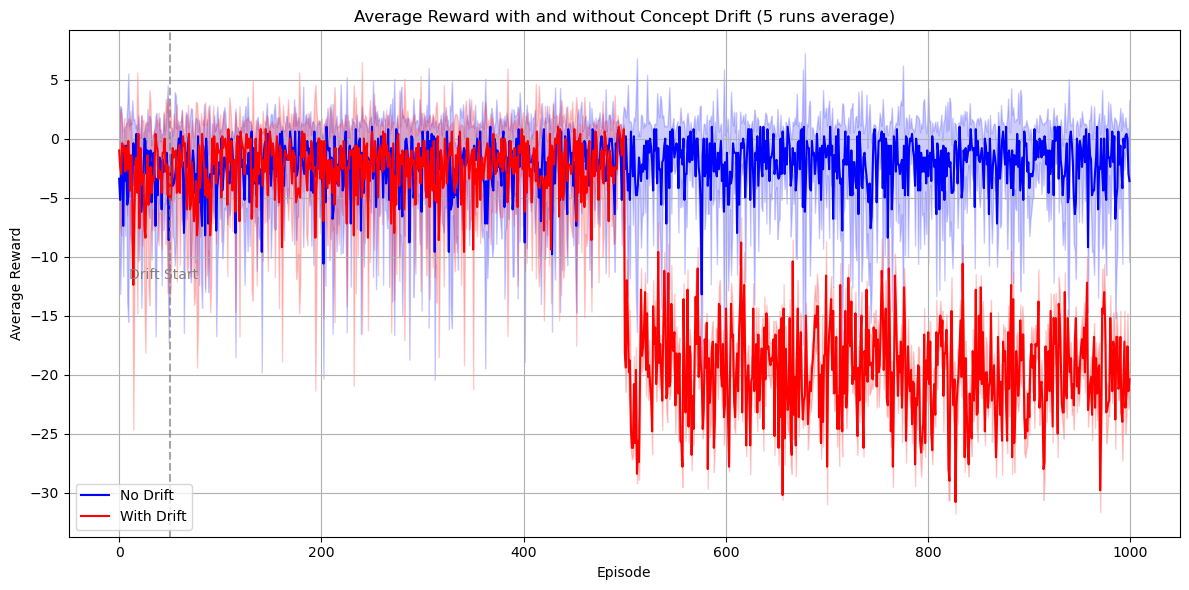

In [6]:
# 运行无drift和有drift的实验 , inverse sudden drift
print("Running experiments without drift...")
avg_no_drift, std_no_drift = run_multiple_trials(apply_drift=False)


print("\nRunning experiments with drift...")
avg_with_drift, std_with_drift = run_multiple_trials(apply_drift=True)



reward_plot(avg_no_drift,std_no_drift,avg_with_drift,std_with_drift)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import cycle
import pandas as pd
import os
from typing import Dict, List, Tuple, Any

In [ ]:

class DriftExperimentManager:
    """管理不同类型drift的实验"""
    
    def __init__(self, output_dir="results"):
        """初始化实验管理器
        
        Args:
            output_dir: 结果输出目录
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # 基础配置
        self.base_config = {
            'no_drift': {
                'name': 'No Drift',
                'apply_drift': False,
                'color': 'blue'
            }
        }
        
    def define_drift_configs(self, drift_configs=None):
        """定义不同的drift类型配置
        
        Args:
            drift_configs: 自定义的drift配置，如果为None则使用默认配置
        
        Returns:
            设置的drift配置字典
        """
        if drift_configs is None:
            # 默认drift配置
            self.drift_configs = {
                'random_transition': {
                    'name': 'random Transition',
                    'apply_drift': True,
                    'drift_params': {
                        'add_actions': 0,
                        'change_at_states': ['va', 'po', 'sib', 'pp'],
                        'drift_dis_type': "random",
                        'intensity': 1.0
                    },
                    'color': 'red'
                },
                'similar_transition': {
                    'name': ' similar Transition',
                    'apply_drift': True,
                    'drift_params': {
                        'add_actions': 0,
                        'change_at_states': ['va', 'po', 'sib', 'pp'],
                        'drift_dis_type': "similar",
                        'intensity': 0.6
                    },
                    'color': 'green'
                },
                'inverse_transition': {
                    'name': 'Inverse Transition',
                    'apply_drift': True,
                    'drift_params': {
                        'add_actions': 0,
                        'change_at_states': ['va', 'po', 'sib', 'pp'],
                        'drift_dis_type': "inverse",
                        'intensity': 0.8
                    },
                    'color': 'purple'
                }
            }
        else:
            self.drift_configs = drift_configs
        
        # 合并基础配置
        self.all_configs = {**self.base_config, **self.drift_configs}
        return self.all_configs
    
    def create_drift_type_variations(self):
        """创建不同drift_dis_type的配置变体
        
        Returns:
            drift_dis_type变体配置字典
        """
        drift_types = ["random", "similar", "inverse"]
        configs = {}
        colors = ['red', 'green', 'purple', 'orange', 'cyan']
        
        for i, dtype in enumerate(drift_types):
            configs[f'drift_type_{dtype}'] = {
                'name': f'Drift Type: {dtype}',
                'apply_drift': True,
                'drift_params': {
                    'add_actions': 0,
                    'change_at_states': ['va', 'po', 'sib', 'pp'],
                    'drift_dis_type': dtype,
                    'intensity': 0.8
                },
                'color': colors[i % len(colors)]
            }
            
        return {**self.base_config, **configs}
    
    def create_state_change_variations(self, drift_dis_type="random"):
        """创建不同change_at_states的配置变体
        
        Args:
            drift_dis_type: 使用的drift分布类型
            
        Returns:
            state变化配置字典
        """
        states = ['va', 'po', 'sib', 'pp']
        configs = {}
        colors = ['red', 'green', 'purple', 'orange', 'cyan']
        
        # 单状态变化
        for i, state in enumerate(states):
            configs[f'state_change_{state}'] = {
                'name': f'State Change: {state}',
                'apply_drift': True,
                'drift_params': {
                    'add_actions': 0,
                    'change_at_states': [state],
                    'drift_dis_type': drift_dis_type,
                    'intensity': 0.8
                },
                'color': colors[i % len(colors)]
            }
        
        # 多状态组合变化
        configs['state_change_all'] = {
            'name': 'State Change: All',
            'apply_drift': True,
            'drift_params': {
                'add_actions': 0,
                'change_at_states': states,
                'drift_dis_type': drift_dis_type,
                'intensity': 0.8
            },
            'color': 'brown'
        }
            
        return {**self.base_config, **configs}
    
    def run_single_experiment(self, config, total_episodes=1000, drift_episode=500):
        """运行单个实验并返回奖励历史
        
        Args:
            config: drift配置
            total_episodes: 总episode数
            drift_episode: drift发生的episode
            
        Returns:
            reward历史记录
        """
        env = TaskEnv_driftype()
        agent = Q_learning_Agent(env)
        reward_history = []
        
        for episode in range(total_episodes):
            # 应用drift
            if config.get('apply_drift', False) and episode == drift_episode:
                env.set_flag()
                try:
                    env.drift(**config.get('drift_params', {}))
                    print(f"{config['name']} drift applied at episode {episode}")
                except Exception as e:
                    print(f"Error applying drift: {e}")
            
            state = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                action = agent.select_action(state)
                next_state, reward, done, _ = env.step(action)
                agent.learn(state, action, next_state, reward, done)
                state = next_state
                episode_reward += reward
            
            reward_history.append(episode_reward)
        
        return reward_history

    def run_multiple_trials(self, config, num_runs=5, total_episodes=100, drift_episode=50):
        """多次运行实验并返回平均结果
        
        Args:
            config: drift配置
            num_runs: 运行次数
            total_episodes: 总episode数
            drift_episode: drift发生的episode
            
        Returns:
            平均奖励和标准差
        """
        all_results = []
        
        for _ in tqdm(range(num_runs), desc=f"Running {config['name']}"):
            results = self.run_single_experiment(config, total_episodes, drift_episode)
            all_results.append(results)
        
        # 计算统计量
        avg_rewards = np.mean(all_results, axis=0)
        std_rewards = np.std(all_results, axis=0)
        
        return avg_rewards, std_rewards
    
    def run_experiments(self, configs, num_runs=5, total_episodes=100, drift_episode=50):
        """运行一组实验
        
        Args:
            configs: 要运行的配置字典
            num_runs: 每个配置的运行次数
            total_episodes: 总episode数
            drift_episode: drift发生的episode
            
        Returns:
            实验结果字典
        """
        results = {}
        for config_name, config in configs.items():
            print(f"\nRunning experiment: {config['name']}")
            avg_rewards, std_rewards = self.run_multiple_trials(
                config, num_runs, total_episodes, drift_episode
            )
            results[config_name] = {
                'avg': avg_rewards,
                'std': std_rewards,
                'color': config['color'],
                'name': config['name']
            }
            
        return results
    
    def visualize_results(self, results, title, filename, drift_episode=50):
        """可视化实验结果
        
        Args:
            results: 实验结果字典
            title: 图表标题
            filename: 保存的文件名
            drift_episode: drift发生的episode
        """
        plt.figure(figsize=(14, 7))
        line_styles = cycle(['-', '--', '-.', ':'])  # 不同的线型

        # 绘制所有曲线
        for config_name, data in results.items():
            linestyle = next(line_styles)
            plt.plot(data['avg'], 
                    label=data['name'], 
                    color=data['color'],
                    linestyle=linestyle,
                    linewidth=2)
            plt.fill_between(range(len(data['avg'])),
                            data['avg'] - data['std'],
                            data['avg'] + data['std'],
                            alpha=0.15, 
                            color=data['color'])

        # 标记drift发生位置
        plt.axvline(x=drift_episode, color='gray', linestyle='--', alpha=0.7)
        plt.text(drift_episode + 10, plt.ylim()[0] + 0.05*(plt.ylim()[1]-plt.ylim()[0]), 
                'Drift Start', 
                rotation=0, 
                color='gray')

        # 图表装饰
        plt.title(f'{title}\n(5 runs average with std shaded)', fontsize=14)
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Average Reward', fontsize=12)
        plt.legend(fontsize=10, loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # 保存结果
        plt.savefig(os.path.join(self.output_dir, filename), dpi=300)
        plt.show()

    def print_statistics(self, results):
        """打印关键统计数据
        
        Args:
            results: 实验结果字典
        """
        print("\nFinal Performance Comparison (last 100 episodes average):")
        for config_name, data in results.items():
            final_perf = np.mean(data['avg'][-100:])
            print(f"{data['name']}: {final_perf:.2f} ± {np.mean(data['std'][-100:]):.2f}")
    
    def export_results_to_csv(self, results, filename):
        """将结果导出到CSV文件
        
        Args:
            results: 实验结果字典
            filename: CSV文件名
        """
        # 创建DataFrame存储平均奖励
        df_avg = pd.DataFrame({
            data['name']: data['avg'] for _, data in results.items()
        })
        
        # 创建DataFrame存储标准差
        df_std = pd.DataFrame({
            f"{data['name']}_std": data['std'] for _, data in results.items()
        })
        
        # 合并并保存
        result_df = pd.concat([df_avg, df_std], axis=1)
        result_df.to_csv(os.path.join(self.output_dir, filename), index=True)
        print(f"Results saved to {filename}")
    
    def run_all_experiments(self):
        """运行所有实验并生成可视化对比
        """
        # 1. 基本drift类型对比
        print("\n===== Running Basic Drift Type Comparison =====")
        self.define_drift_configs()
        basic_results = self.run_experiments(self.all_configs)
        
        self.visualize_results(
            basic_results,
            'Q-learning Performance Under Different Transition Drift Types',
            'basic_drift_comparison.png'
        )
        #self.print_statistics(basic_results)
        self.export_results_to_csv(basic_results, 'basic_drift_results.csv')
        
        # 2. 不同drift类型变体对比
        print("\n===== Running Drift Distribution Type Comparison =====")
        drift_type_configs = self.create_drift_type_variations()
        drift_type_results = self.run_experiments(drift_type_configs)
        
        self.visualize_results(
            drift_type_results,
            'Q-learning Performance Under Different Drift Distribution Types',
            'drift_type_comparison.png'
        )
        #self.print_statistics(drift_type_results)
        self.export_results_to_csv(drift_type_results, 'drift_type_results.csv')
        
        # 3. 不同状态变化对比
        for drift_type in ["random", "similar", "inverse"]:
            print(f"\n===== Running State Change Comparison with {drift_type} distribution =====")
            state_change_configs = self.create_state_change_variations(drift_type)
            state_change_results = self.run_experiments(state_change_configs)
            
            self.visualize_results(
                state_change_results,
                f'Q-learning Performance With Different State Changes ({drift_type} distribution)',
                f'state_change_{drift_type}_comparison.png'
            )
            self.print_statistics(state_change_results)
            self.export_results_to_csv(state_change_results, f'state_change_{drift_type}_results.csv')


# 使用示例
if __name__ == "__main__":
    # 创建实验管理器
    manager = DriftExperimentManager(output_dir="drift_results")
    
    # 运行所有实验
    manager.run_all_experiments()
    
    # 也可以运行单个实验组
    # manager.define_drift_configs()
    # results = manager.run_experiments(manager.all_configs)
    # manager.visualize_results(results, 'Basic Drift Comparison', 'custom_drift_comparison.png')